In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn import metrics
from argparse import Namespace
from pathlib import Path
import pandas as pd
import pyarrow
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from collections import Counter
from nltk import ngrams
import string
import re
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-1-e841c7a840bb>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


/home/manuto/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Arguments

In [2]:
args = Namespace()
args.country_code='US'
args.model_type='paraphrase-xlm-r-multilingual-v1'
args.inference_folder = 'iter_0-convbert-test-48-10-900-1538433-new_samples'

In [3]:
model = SentenceTransformer(args.model_type)

## Utils

In [4]:
def get_elbow_data(embeddings, k_max):
    distortions = []
    K = range(1,k_max)
    for k in tqdm(K):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(embeddings)
        distortions.append(kmeanModel.inertia_)
    return distortions

In [5]:
def get_elbow_graph(distortions, k_max):
    K = range(1,k_max)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [6]:
def perform_k_means(embeddings, num_clusters, corpus_df):
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    cluster_assignment = clustering_model.labels_
    clustered_sentences = [[] for i in range(num_clusters)]
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clustered_sentences[cluster_id].append(corpus_df['text'].tolist()[sentence_id])
    return clustered_sentences, cluster_assignment

In [7]:
def get_most_common_ngrams(tweet_list, n, topk):
    tweet_str = " ".join(tweet_list)
    for character in string.punctuation:
        tweet_str = tweet_str.replace(character, " ")
    tweet_str = tweet_str.lower()
    tweet_str = re.sub('http\S+', ' ', tweet_str)
    ngram_counts = Counter(ngrams(tweet_str.split(), n))
    return ngram_counts.most_common(topk)

In [8]:
def clean_tweets(tweet_list):
    return [re.sub('http\S+', ' ', tweet_str) for tweet_str in tweet_list]        

In [9]:
labor_data_path = '/home/manuto/Documents/world_bank/bert_twitter_labor/twitter-labor-data/data'
data_path = f'{labor_data_path}/top_tweets/US/{args.inference_folder}'

# lost_job_1mo

In [10]:
merged_df = pd.read_parquet(os.path.join(data_path, 'lost_job_1mo', 'part-00000-ebff68f0-0d09-4ee8-9baf-973096aac49d-c000.snappy.parquet'))

In [11]:
merged_df.head()

,tweet_id,score,text
0,478895917076996096,0.996264,Just got laid off yesterday
1,9304190585,0.996260,Got laid off today. One word: SUCK!
2,1213252097208147969,0.996126,Got jerked off today.
3,687510370458726401,0.996099,"I was thrown away today, https://t.co/HX54RggMnd"
4,1181783394549673985,0.996057,Just got pushed away. How’s y’alls day going 🎃


In [12]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

In [13]:
distortions = get_elbow_data(corpus_embeddings, 60)

<ipython-input-4-6fdf21a060c6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(K):


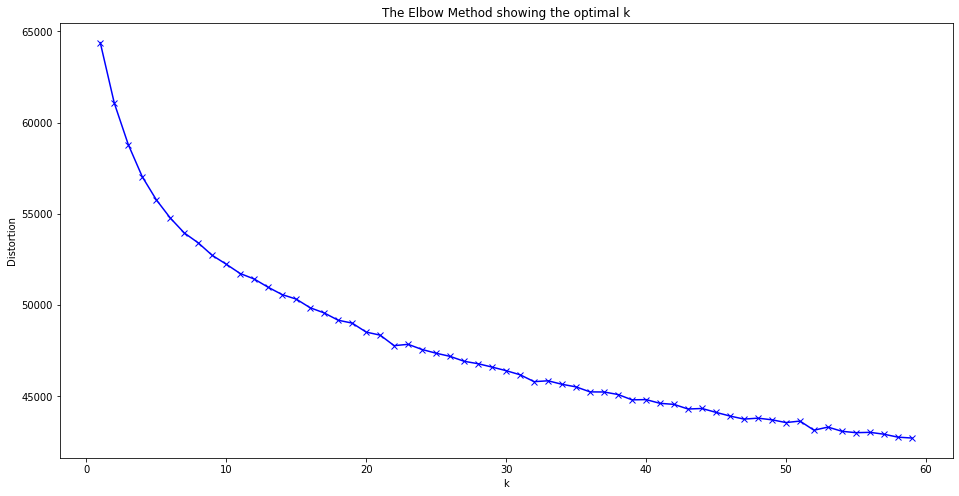

In [14]:
get_elbow_graph(distortions, 60)

In [ ]:
get_elbow_graph(corpus_embeddings)

In [ ]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=15, corpus_df=merged_df)


In [ ]:
merged_df = merged_df.sort_values(by=['cluster'], ascending=True).reset_index(drop=True)
merged_df.head()

In [23]:
output_path = f'{labor_data_path}/evaluation_inference/clustering/US/{args.inference_folder}'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [ ]:
merged_df.to_parquet(os.path.join(output_path, 'kmeans', 'lost_job_1mo.parquet'), index=False)

In [ ]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

In [ ]:
list_1=get_most_common_ngrams(cluster_1_tweets_list, n=4, topk=20)

In [ ]:
list_2=get_most_common_ngrams(cluster_2_tweets_list, n=4, topk=20)

In [ ]:
get_most_common_ngrams(cluster_2_tweets_list, n=2, topk=20)[0][0]

In [ ]:
def difference_ngrams(list_1, list_2, n):
    if len(list_1) == len(list_2):
        list_ngram_1 = list()
        list_ngram_2 = list()
        for ngram_block in list_1:
            list_ngram_1.append(ngram_block[0])
        for ngram_block in list_2:
            list_ngram_2.append(ngram_block[0])
        inter_list = list(set(list_ngram_1).intersection(list_ngram_2))
        print(f'{str(100*len(inter_list)/len(list_ngram_1))}% of {str(n)}-grams in common')
        print(f'*******{str(n)} grams in common:*******', *inter_list, sep='\n')
        print(f'*******{str(n)} grams specific to cluster 1:*******', *[ngram for ngram in list_ngram_1 if ngram not in inter_list], sep='\n')
        print(f'*******{str(n)} grams specific to cluster 2:*******', *[ngram for ngram in list_ngram_2 if ngram not in inter_list], sep='\n')


## is_hired_1mo:

In [11]:
merged_df = pd.read_parquet(os.path.join(data_path, 'is_hired_1mo', 'part-00000-a198c90e-2bef-4416-abe2-1eaf85f7e391-c000.snappy.parquet'))

In [12]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

In [23]:
def calculate_silhouette_coeff(corpus_embeddings, n_clusters_max):
    silhouette_score_dict = dict()
    for n in range(2,n_clusters_max):
        print(n)
        kmeans_model = KMeans(n_clusters=n, random_state=1).fit(corpus_embeddings)
        labels = kmeans_model.labels_
        silhouette_score = metrics.silhouette_score(corpus_embeddings, labels, metric='euclidean')
        silhouette_score_dict[n] = silhouette_score
    return silhouette_score_dict

In [24]:
silhouette_score_dict = calculate_silhouette_coeff(corpus_embeddings, 60)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [25]:
max(silhouette_score_dict, key=silhouette_score_dict.get)

2

In [26]:
silhouette_score_dict

{2: 0.06646883,
 3: 0.04937488,
 4: 0.04293793,
 5: 0.04543395,
 6: 0.04541443,
 7: 0.038987443,
 8: 0.038778007,
 9: 0.036777727,
 10: 0.038017638,
 11: 0.033817198,
 12: 0.036907874,
 13: 0.042861983,
 14: 0.039188445,
 15: 0.041425623,
 16: 0.036309324,
 17: 0.04199333,
 18: 0.04373534,
 19: 0.038691457,
 20: 0.040262293,
 21: 0.03919709,
 22: 0.03792062,
 23: 0.0387673,
 24: 0.040683057,
 25: 0.041066673,
 26: 0.041632183,
 27: 0.04236858,
 28: 0.04204919,
 29: 0.042527042,
 30: 0.043047663,
 31: 0.042652693,
 32: 0.043910492,
 33: 0.04029105,
 34: 0.042590503,
 35: 0.04350058,
 36: 0.042455822,
 37: 0.042100497,
 38: 0.042044632,
 39: 0.044794146,
 40: 0.044057906,
 41: 0.044506706,
 42: 0.046019394,
 43: 0.044095885,
 44: 0.04494251,
 45: 0.044559296,
 46: 0.044199787,
 47: 0.044860262,
 48: 0.043408196,
 49: 0.042325646,
 50: 0.042700358,
 51: 0.042872146,
 52: 0.039588157,
 53: 0.036898933,
 54: 0.03621389,
 55: 0.04038667,
 56: 0.033565503,
 57: 0.03823397,
 58: 0.0360876,
 59

In [16]:
distortions = get_elbow_data(corpus_embeddings, 60)

<ipython-input-14-6fdf21a060c6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(K):


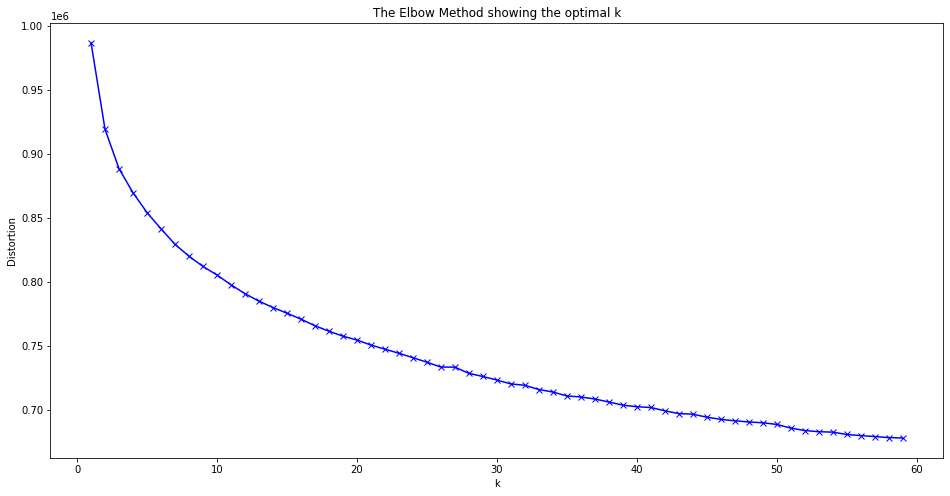

In [17]:
get_elbow_graph(distortions, 60)

In [18]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=15, corpus_df=merged_df)
# cluster_1_tweets_list = cluster_tweets[0]
# cluster_2_tweets_list = cluster_tweets[1]
# cluster_3_tweets_list = cluster_tweets[2]
# cluster_4_tweets_list = cluster_tweets[3]

In [21]:
merged_df = merged_df.sort_values(by=['cluster'], ascending=True).reset_index(drop=True)
merged_df.head()

,tweet_id,score,text,cluster
0,1238987595088039936,0.966101,Last night... Great start to the new job https...,0
1,362359550206152705,0.970191,Got the job with Verizon start tomorrow at 1:0...,0
2,621755073312464896,0.971249,Start my new job Monday bartending two paychec...,0
3,587745572443951104,0.972267,Starting my awesome new job tomorrow! #tubecit...,0
4,1155160750773669891,0.972265,im so excited to start my new job. this change...,0


In [24]:
merged_df.to_parquet(os.path.join(output_path, 'kmeans', 'is_hired_1mo.parquet'), index=False)

In [ ]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

In [ ]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

In [ ]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

## is_unemployed

In [10]:
merged_df = pd.read_parquet(os.path.join(data_path, 'is_unemployed', 'part-00000-3e2a1206-25bd-4bc5-84ed-24d2b747deb5-c000.snappy.parquet'))

In [11]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

In [12]:
distortions = get_elbow_data(corpus_embeddings, 60)

<ipython-input-4-6fdf21a060c6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(K):


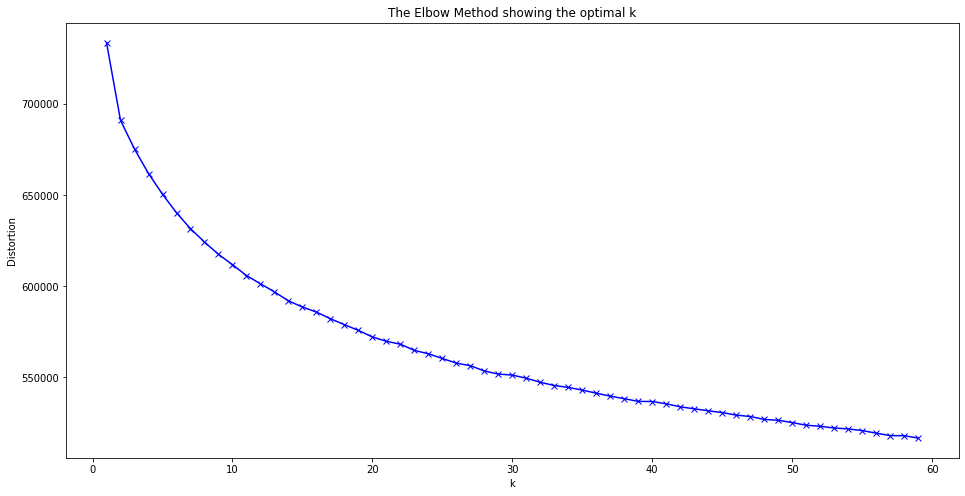

In [13]:
get_elbow_graph(distortions, 60)

In [15]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=15, corpus_df=merged_df)
# cluster_1_tweets_list = cluster_tweets[0]
# cluster_2_tweets_list = cluster_tweets[1]
# cluster_3_tweets_list = cluster_tweets[2]
# cluster_4_tweets_list = cluster_tweets[3]

In [16]:
merged_df = merged_df.sort_values(by=['cluster'], ascending=True).reset_index(drop=True)
merged_df.head()

,tweet_id,score,text,cluster
0,371758108613562369,0.987723,@jackienicholex DO NOT. SAY THAT. IM TERRIFIED...,0
1,482725203773251584,0.987295,Trying to go out !,0
2,297386182529142784,0.987513,"oh, COME ON GUYS. i'm KIDDING. jesus christ.",0
3,276874384268988418,0.987294,"""You know you love me. XOXO Gossip Girl."" IM O...",0
4,106928712175468544,0.987294,I LOVE PARTYING!!!! I AM ADDICTED!,0


In [18]:
output_path = f'{labor_data_path}/evaluation_inference/clustering/US/{args.inference_folder}'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [19]:
merged_df.to_parquet(os.path.join(output_path, 'kmeans', 'is_unemployed.parquet'), index=False)

In [ ]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

In [ ]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

In [ ]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

## job_search:

In [30]:
merged_df = pd.read_parquet(os.path.join(data_path, 'job_search', 'part-00000-03b5c308-528e-4697-93c0-40606690f546-c000.snappy.parquet'))

In [31]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

In [ ]:
silhouette_score_dict = calculate_silhouette_coeff(corpus_embeddings, 60)

In [22]:
distortions = get_elbow_data(corpus_embeddings, 60)

<ipython-input-4-6fdf21a060c6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(K):


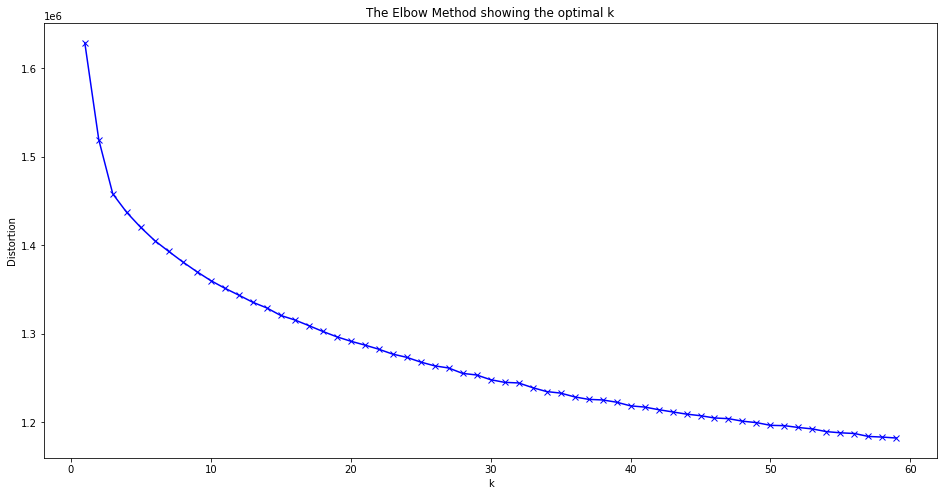

In [23]:
get_elbow_graph(distortions, 60)

In [32]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=15, corpus_df=merged_df)
# cluster_3_tweets_list = cluster_tweets[2]
# cluster_4_tweets_list = cluster_tweets[3]

In [33]:
merged_df = merged_df.sort_values(by=['cluster'], ascending=True).reset_index(drop=True)
merged_df.head()

,tweet_id,score,text,cluster
0,25159725561,0.997100,have a job interview tomorrow. just now realiz...,0
1,192333942337191938,0.997001,Interview Friday pray i get it,0
2,8322958336,0.997001,I got a job interview!,0
3,291262892647534593,0.997219,Interview ... Wish me luck 😳😁,0
4,636006642878967808,0.997141,Job interview tomorrow 😁😧☺️😱,0


In [34]:
output_path = f'{labor_data_path}/evaluation_inference/clustering/US/{args.inference_folder}'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [35]:
merged_df.to_parquet(os.path.join(output_path, 'kmeans', 'job_search.parquet'), index=False)

In [ ]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

In [ ]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

In [ ]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

## job_offer

In [22]:
merged_df = pd.read_parquet(os.path.join(data_path, 'job_offer', 'part-00000-e0ac7335-f3ad-42b4-833f-7071588b5e65-c000.snappy.parquet'))

In [23]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

In [ ]:
distortions = get_elbow_data(corpus_embeddings, 60)

<ipython-input-16-6fdf21a060c6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(K):


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


In [ ]:
get_elbow_graph(corpus_embeddings)

In [ ]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=4, corpus_df=merged_df)
cluster_1_tweets_list = cluster_tweets[0]
cluster_2_tweets_list = cluster_tweets[1]
cluster_3_tweets_list = cluster_tweets[2]
cluster_4_tweets_list = cluster_tweets[3]

In [ ]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

In [ ]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

In [ ]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

In [ ]:
get_most_common_ngrams(cluster_3_tweets_list, n=3, topk=20)

In [ ]:
get_most_common_ngrams(cluster_4_tweets_list, n=3, topk=20)